In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

from scipy.io import loadmat
import scipy.linalg as spl

# Testing + computing sensitivities 

In [2]:
kuangdata = loadmat("steadyLRF.mat")

M=kuangdata['M']
pres=kuangdata['pres']
tmean=kuangdata['tmean']
qmean=kuangdata['qmean']
zrce = kuangdata['z']

In [3]:
#Reverse positive eigenvalue
lambdas,P = spl.eig(M)
lambdas[5]*=-1
Pm1 = spl.inv(P)
M2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Qq response (g/kg/day)')

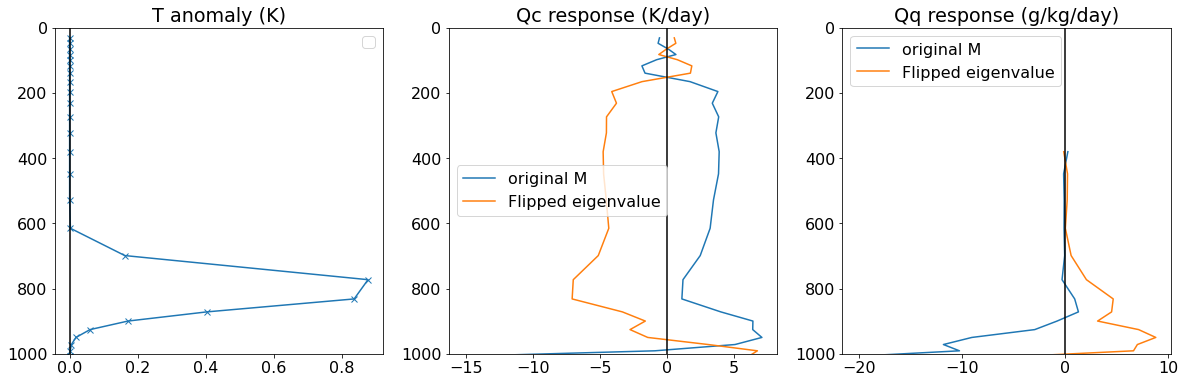

In [4]:
testT = np.exp(-((pres[:-2]-800)/75)**2)[:,0]
testq = np.zeros(14)
testforcing=np.concatenate((testT,testq))
reps = np.dot(M,testforcing);   repQc = reps[:26];   repQq = reps[26:]
reps2 = np.dot(M2,testforcing); repQc2 = reps2[:26]; repQq2 = reps2[26:]

_,axs=plt.subplots(1,3,figsize=(20,6))
axs[0].plot(testT,pres[:-2],'-x')
axs[1].plot(repQc,pres[:-2] ,label="original M")
axs[1].plot(repQc2,pres[:-2],label="Flipped eigenvalue")
axs[2].plot(repQq,pres[:-14] ,label="original M")
axs[2].plot(repQq2,pres[:-14],label="Flipped eigenvalue")
for ax in axs:
    ax.set_ylim(1000,0)
    ax.axvline(0.,color='k')
    ax.legend()
axs[0].set_title("T anomaly (K)")
axs[1].set_title("Qc response (K/day)")
axs[2].set_title("Qq response (g/kg/day)")

Text(0.5, 1.0, 'Qc (K/day)')

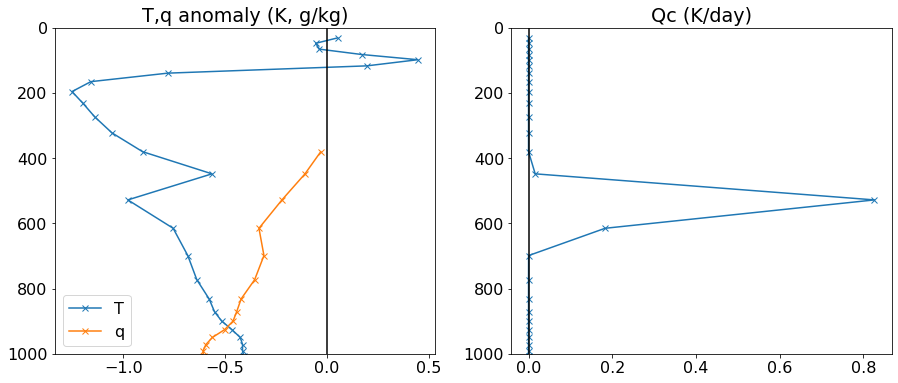

In [5]:
testQc = np.exp(-((pres[:-2]-550)/50)**2)[:,0]
testQq = np.zeros(14)
testforcing=np.concatenate((testQc,testQq))
reps= np.dot(spl.inv(M2),testforcing); repT = reps[:26]; repq = reps[26:]

_,axs=plt.subplots(1,2,figsize=(15,6))
axs[0].plot(repT,pres[:-2],'-x' ,label='T')
axs[0].plot(repq,pres[:-14],'-x',label='q')
axs[1].plot(testQc,pres[:-2],'-x')
for ax in axs:
    ax.set_ylim(1000,0)
    ax.axvline(0.,color='k')
    
axs[0].set_title("T,q anomaly (K, g/kg)")
axs[0].legend()
axs[1].set_title("Qc (K/day)")

In [6]:
def QcQqfromTq(forcT,forcq):
    forcing=np.concatenate((forcT,forcq))
    reps = np.dot(M2,forcing)
    repQc = reps[:26]
    repQq = reps[26:]
    return repQc,repQq

def plot_response(forcT,forcq,axs=None,tkwargs={},qkwargs={}):
    repQc,repQq = QcQqfromTq(forcT,forcq)
    
    if axs is None:
        _,axs=plt.subplots(1,2,figsize=(15,6))
    axs[0].plot(forcT,pres[:-2] ,marker='x',label="T",**tkwargs)
    axs[0].plot(forcq,pres[:-14],marker='o',label="q",**qkwargs)
    axs[1].plot(repQc,pres[:-2] ,marker='x',label="Qc",**tkwargs)
    axs[1].plot(repQq,pres[:-14],marker='o',label="Qq",**qkwargs)
    
    for ax in axs:
        ax.set_ylim(1010,0)
        ax.axvline(0.,color='k')
        ax.legend()
    axs[0].set_title("T/q anomaly (K,g/kg)")
    axs[1].set_title("Qc/Qq response (K/day,g/kg/day)")

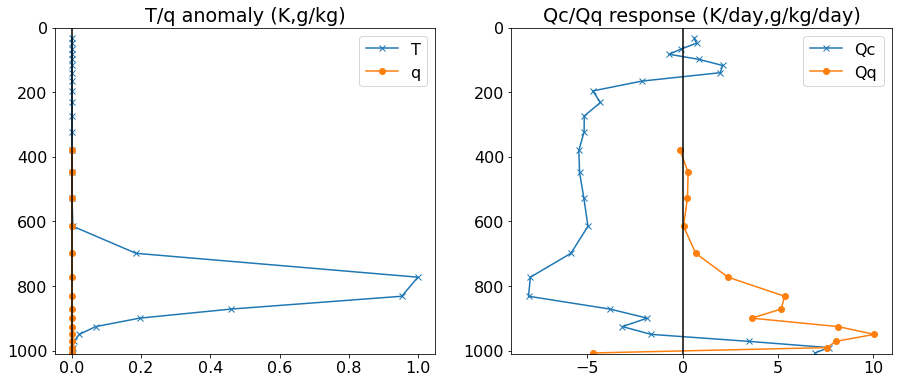

In [7]:
testT = np.exp(-((pres[:-2]-800)/75)**2)[:,0]#np.zeros(26)
testq = np.zeros(14)#np.exp(-((pres[:-14]-600)/75)**2)[:,0]
testT/=testT.max()
plot_response(testT,testq)

In [8]:
def precip_Jkgday(forcT,forcq):
    forcing=np.concatenate((forcT,forcq))
    reps = np.dot(M2,forcing)
    repQc = reps[:26]
    pr = np.trapz(repQc,pres[:-2,0])*1004/(pres[-3,0]-pres[0,0])
    return pr

forcT = np.zeros(26); forcT[6:11]=1
forcq = np.zeros(14)
tau_hours = 1004./precip_Jkgday(forcT,forcq)*24
print("Lower-tropospheric T: tau = %.2f hrs"%tau_hours)

forcT = np.zeros(26)
forcq = np.zeros(14); forcq[6:11]=1
tau_hours = 2.5e3/precip_Jkgday(forcT,forcq)*24
print("Lower-tropospheric q: tau = %.2f hrs"%tau_hours)

forcT = np.zeros(26); forcT[:4]=1
forcq = np.zeros(14)
tau_hours = 1004./precip_Jkgday(forcT,forcq)*24
print("Boundary layer T: tau = %.2f hrs"%tau_hours)

forcT = np.zeros(26)
forcq = np.zeros(14); forcq[:4]=1
tau_hours = 2.5e3/precip_Jkgday(forcT,forcq)*24
print("Boundary layer q: tau = %.2f hrs"%tau_hours)


Lower-tropospheric T: tau = -2.97 hrs
Lower-tropospheric q: tau = 18.42 hrs
Boundary layer T: tau = 8.99 hrs
Boundary layer q: tau = 12.10 hrs


# Wavelike forcings

In [9]:
import xarray as xr; xr.set_options(display_style='text') 

import os
import sys
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,linear_precip_theory
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,w_to_Tprime,w_to_qprime
from orographicPrecipitation.wrfProcessing.wrf_hr_utils import *

from scipy.interpolate import interp1d

In [15]:
N=0.01;U=10
m = N/U
zbase=np.linspace(0,30e3,100)
xx,hx=topographic_profile('cos')
w=linear_w_1layer(xx,hx,zbase,U,N)
Tprime_wave=w_to_Tprime(w,U,N).sel(distance_from_mtn=-200)
qprime_wave=w_to_qprime(w,U).sel(distance_from_mtn=-200)
Tprime_wave_interp = np.interp(zrce[:,0],zbase,Tprime_wave)
qprime_wave_interp = np.interp(zrce[:,0],zbase,qprime_wave)


precip: 10.40 mm/day


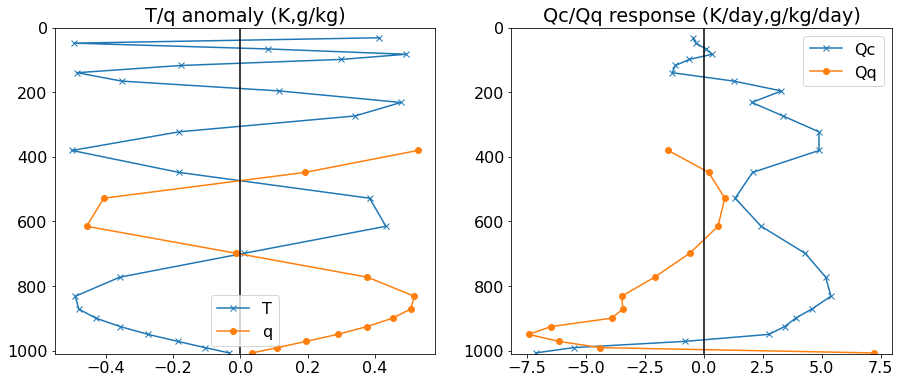

In [16]:
plot_response(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14])
print("precip: %.2f mm/day"%(precip_Jkgday(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14])/2.5e6*1e4))

In [17]:
ref = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfpout_d01_1970-01-01_00_00_00")
deepchannel_w = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W_PL.days100-250.nc"); deepchannel_w=deepchannel_w.where(deepchannel_w>-10.)
w_WRF = change_coords_pl(ref,deepchannel_w).sel(distance_from_mtn=-200,method='nearest')

In [20]:
deepchannel_T = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc"); deepchannel_T=deepchannel_T.where(deepchannel_T>deepchannel_T[:,2200:2400].mean('west_east')-5)
deepchannel_q = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.Q_PL.days100-250.nc"); deepchannel_q=deepchannel_q.where(deepchannel_q>deepchannel_q[:,2200:2400].mean('west_east')-0.005)
def prime(var):
    return var-var.isel(west_east=slice(2200,3000)).mean('west_east')
Tprime_WRF = change_coords_pl(ref,prime(deepchannel_T)).sel(distance_from_mtn=-200,method='nearest')[1:]
qprime_WRF = change_coords_pl(ref,prime(deepchannel_q)).sel(distance_from_mtn=-200,method='nearest')

Tprime_WRF_interp = np.interp(pres[::-1,0],np.array(Tprime_WRF.pressure)[::-1],np.array(Tprime_WRF)[::-1])[::-1]
qprime_WRF_interp = np.interp(pres[::-1,0],np.array(qprime_WRF.pressure)[::-1],np.array(qprime_WRF)[::-1])[::-1]


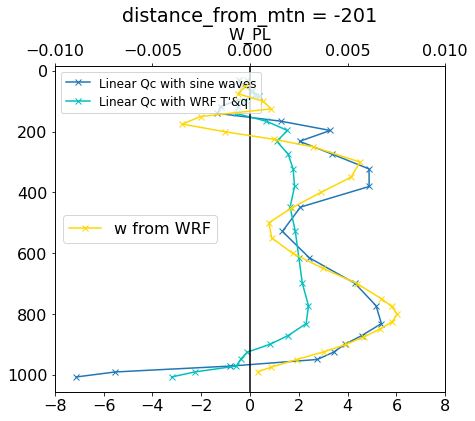

In [22]:
_,ax=plt.subplots(1,1,figsize=(7,6))
ax2=ax.twiny()

repQc_theory,_ = QcQqfromTq(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14])
repQc_WRF   ,_ = QcQqfromTq(Tprime_WRF_interp[:-2],1e3*qprime_WRF_interp[:-14])
ax.plot(repQc_theory,pres[:-2],marker='x',label='Linear Qc with sine waves')
ax.plot(repQc_WRF,pres[:-2],marker='x',color='c',label="Linear Qc with WRF T'&q'")

w_WRF.plot(ax=ax2,y='pressure',yincrease=False,marker='x',color='gold',label='w from WRF')
ax.axvline(0.,color='k')

ax.set_xlim(-8,8)
ax2.set_xlim(-0.01,0.01)
ax2.set_xticks(np.arange(-0.01,0.011,0.005))

ax.legend(loc=2,fontsize=12);ax2.legend(loc=6)

In [146]:
deepchannel_precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc")
deepchannel_pr = change_coords_sfc(deepchannel_precip[400:].mean(['south_north','Time']))

precip: 5.10 mm/day
WRF P': 3.21 mm/day


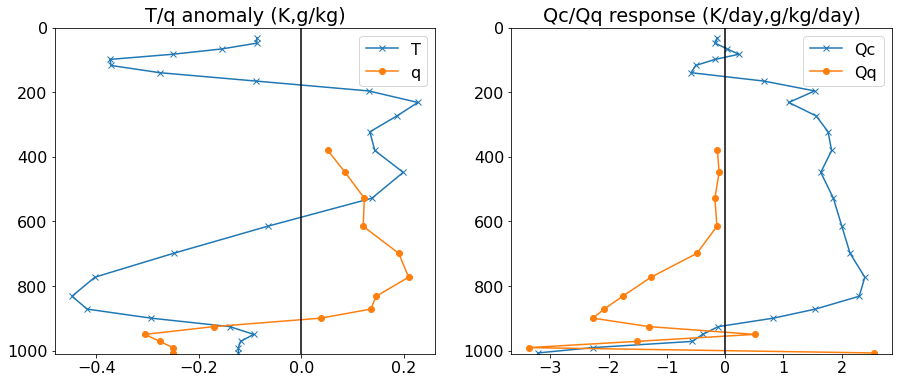

In [148]:
plot_response(Tprime_WRF_interp[:-2],1e3*qprime_WRF_interp[:-14])
print("precip: %.2f mm/day"%(precip_Jkgday(Tprime_WRF_interp[:-2],1e3*qprime_WRF_interp[:-14])/2.5e6*1e4))
print("WRF P': %.2f mm/day"%(deepchannel_pr.sel(distance_from_mtn=-200,method='nearest')-4.))

## Synthetic precip

In [119]:
Tprime_wave=w_to_Tprime(w,U,N).sel(distance_from_mtn=slice(-2000,2000))
qprime_wave=w_to_qprime(w,U).sel(distance_from_mtn=slice(-2000,2000))
Tprime_wave_interp=interp1d(zbase,np.array(Tprime_wave),axis=0,fill_value='extrapolate')(zrce[:,0])
qprime_wave_interp=interp1d(zbase,np.array(qprime_wave),axis=0,fill_value='extrapolate')(zrce[:,0])
Qc_2d = np.dot(M2,np.concatenate((Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14]),axis=0))[:26]
precip_wave=np.trapz(Qc_2d,pres[:-2,0],axis=0)*1004/(pres[-3,0]-pres[0,0])/2.5e6*1e4
precip_wave=xr.DataArray(precip_wave,coords=(Tprime_wave.distance_from_mtn,),dims=['distance_from_mtn'])


In [127]:
Tprime_WRF = change_coords_pl(ref,prime(deepchannel_T))[1:]
qprime_WRF = change_coords_pl(ref,prime(deepchannel_q))[1:]

Tprime_WRF_interp = interp1d(np.array(Tprime_WRF.pressure)[::-1],np.array(Tprime_WRF)[::-1],axis=0,fill_value='extrapolate')(pres[::-1,0])[::-1]
qprime_WRF_interp = interp1d(np.array(qprime_WRF.pressure)[::-1],np.array(qprime_WRF)[::-1],axis=0,fill_value='extrapolate')(pres[::-1,0])[::-1]
Qc_2d = np.dot(M2,np.concatenate((Tprime_WRF_interp[:-2],1e3*qprime_WRF_interp[:-14]),axis=0))[:26]
precip_WRF=np.trapz(Qc_2d,pres[:-2,0],axis=0)*1004/(pres[-3,0]-pres[0,0])/2.5e6*1e4
precip_WRF=xr.DataArray(precip_WRF,coords=(Tprime_WRF.distance_from_mtn,),dims=['distance_from_mtn'])


In [128]:
pr_lintheory = linear_precip_theory(xx,hx,U,tauT=7.5,tauq=27.5,P0=4.,switch=1)

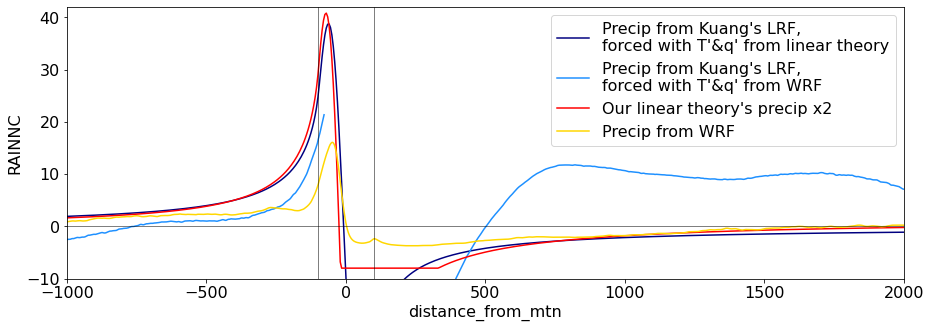

In [133]:
plt.figure(figsize=(15,5))
precip_wave.plot(label="Precip from Kuang's LRF,\nforced with T'&q' from linear theory",color='navy')
precip_WRF .plot(label="Precip from Kuang's LRF,\nforced with T'&q' from WRF",color='dodgerblue')
plt.plot(xx/1000,(pr_lintheory-4)*2,label="Our linear theory's precip x2",color='red')
(deepchannel_pr-4).plot(label="Precip from WRF",color='gold')
plt.xlim(-1000,2000)
plt.axhline(0.,color='k',linewidth=0.5);plt.axvline(-100.,color='k',linewidth=0.5);plt.axvline(100.,color='k',linewidth=0.5)
plt.ylim(-10,42)
plt.legend()

# Perturbing the sinusoidal wave

In [167]:
N=0.01;U=10
m = N/U
zbase=np.linspace(0,30e3,100)
xx,hx=topographic_profile('cos')
w=linear_w_1layer(xx,hx,zbase,U,N)
Tprime_wave=w_to_Tprime(w,U,N).sel(distance_from_mtn=-200)
qprime_wave=w_to_qprime(w,U).sel(distance_from_mtn=-200)
Tprime_wave_interp = np.interp(zrce[:,0],zbase,Tprime_wave)
qprime_wave_interp = np.interp(zrce[:,0],zbase,qprime_wave)


In [192]:
Tprime_wave_interp2=Tprime_wave_interp.copy(); Tprime_wave_interp2[12:]=0
qprime_wave_interp2=qprime_wave_interp.copy(); qprime_wave_interp2[12:]=0
Tprime_wave_interp3=Tprime_wave_interp.copy(); Tprime_wave_interp3[10:]=0
qprime_wave_interp3=qprime_wave_interp.copy(); qprime_wave_interp3[10:]=0
Tprime_wave_interp4=Tprime_wave_interp.copy(); Tprime_wave_interp4[:5]=0
qprime_wave_interp4=qprime_wave_interp.copy(); qprime_wave_interp4[:5]=0

Tprime_wave_interp5=Tprime_wave_interp.copy(); Tprime_wave_interp5[:5]=0; Tprime_wave_interp5[10:]=0
qprime_wave_interp5=qprime_wave_interp.copy(); qprime_wave_interp5[:5]=0; qprime_wave_interp5[10:]=0


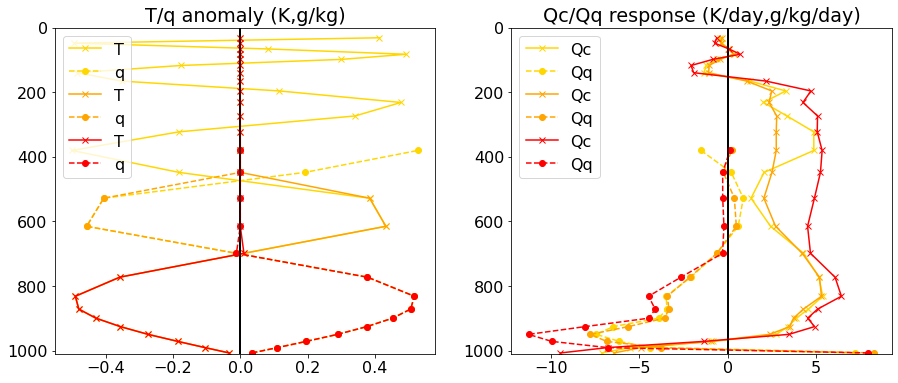

In [186]:
_,axs=plt.subplots(1,2,figsize=(15,6))
plot_response(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14],axs,{'color':'gold'},{'color':'gold','linestyle':'--'})
plot_response(Tprime_wave_interp2[:-2],1e3*qprime_wave_interp2[:-14],axs,{'color':'orange'},{'color':'orange','linestyle':'--'})
plot_response(Tprime_wave_interp3[:-2],1e3*qprime_wave_interp3[:-14],axs,{'color':'red'},{'color':'red','linestyle':'--'})
#plot_response(Tprime_wave_interp4[:-2],1e3*qprime_wave_interp4[:-14],axs,{'color':'brown'},{'color':'brown','linestyle':'--'})
#print("precip: %.2f mm/day"%(precip_Jkgday(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14])/2.5e6*1e4))

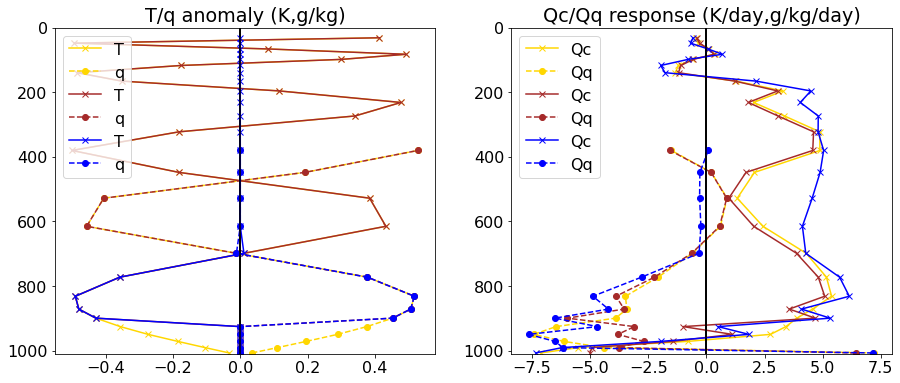

In [193]:
_,axs=plt.subplots(1,2,figsize=(15,6))
plot_response(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14],axs,{'color':'gold'},{'color':'gold','linestyle':'--'})
plot_response(Tprime_wave_interp4[:-2],1e3*qprime_wave_interp4[:-14],axs,{'color':'brown'},{'color':'brown','linestyle':'--'})
plot_response(Tprime_wave_interp5[:-2],1e3*qprime_wave_interp5[:-14],axs,{'color':'b'},{'color':'b','linestyle':'--'})

#print("precip: %.2f mm/day"%(precip_Jkgday(Tprime_wave_interp[:-2],1e3*qprime_wave_interp[:-14])/2.5e6*1e4))

# Convective heating in WRF

In [209]:
hrdist=umean_p.distance_from_mtn

In [219]:
umean_p     = xr.open_dataarray("orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.U_PL.days50-200.mean.nc")
tmean_p     = xr.open_dataarray("orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
omegamean_p = xr.open_dataarray("orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.OMEGA_PL.days50-200.mean.nc")
thetamean_p = xr.open_dataarray("orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.THETA_PL.days50-200.mean.nc")

plevs_875 = np.array(umean_p.pressure[::-1])
DeltaP=150-875



In [216]:
%%time
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepQrad = deepchannel.RTHRATEN.sel(Time=slice(400,500)).mean(['Time','south_north'])*86400
deepQrad_p = interp_eta_to_pressure(deepchannel,change_coords_eta(deepchannel,deepQrad),staggered=0,plevs=plevs_875,dsinput=deepinput)

CPU times: user 8.48 s, sys: 18.1 s, total: 26.6 s
Wall time: 24.7 s


In [220]:
pi = (tmean_p.pressure/1e3)**0.286
udtdx = -(umean_p*tmean_p.differentiate('distance_from_mtn')/1000 * 86400)
omegadsdp = (pi*omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400)
Qdiab = udtdx+omegadsdp- deepQrad_p

In [232]:
matplotlib.rcParams.update({'font.size': 16})

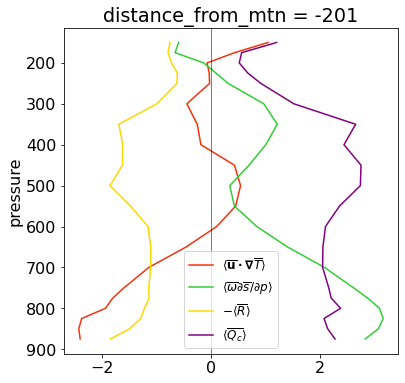

In [236]:
plt.figure(figsize=(6,6))
udtdx     .sel(distance_from_mtn=-200,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion")
omegadsdp .sel(distance_from_mtn=-200,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen")
deepQrad_p.sel(distance_from_mtn=-200,method='nearest').plot(y='pressure',yincrease=False,label=r"$-\langle \overline{R}                                    \rangle$", color='gold')
Qdiab     .sel(distance_from_mtn=-200,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple")
plt.axvline(0.,color='k',linewidth=0.5)
plt.legend(fontsize=12)


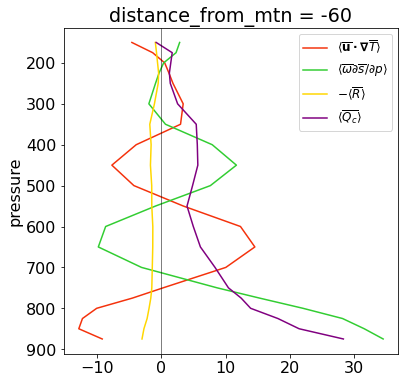

In [239]:
plt.figure(figsize=(6,6))
udtdx     .sel(distance_from_mtn=-60,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion")
omegadsdp .sel(distance_from_mtn=-60,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen")
deepQrad_p.sel(distance_from_mtn=-60,method='nearest').plot(y='pressure',yincrease=False,label=r"$-\langle \overline{R}                                    \rangle$", color='gold')
Qdiab     .sel(distance_from_mtn=-60,method='nearest').plot(y='pressure',yincrease=False,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple")
plt.axvline(0.,color='k',linewidth=0.5)
plt.legend(fontsize=12)
